In [1]:
!nvidia-smi

Wed Sep 27 09:35:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 30%   40C    P8    49W / 300W |      1MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q pyspellchecker textstat

In [3]:
!pip install lightgbm==3.3.2 xgboost==1.7.6 catboost==1.2.1

In [4]:
import os

class Config:
    AUTHOR = "wanwan7123"

    NAME = "commonlit-exp022-deberta-v3-large"
    MODEL_PATH = "microsoft/deberta-v3-large"
    ROOT = "/notebooks"

    apex=True
    seed = 42
    num_fold = 4
    trn_fold = [0, 1, 2, 3]
    batch_size = 16
    n_epochs = 3
    max_len = 1024
    target_list = ["content", "wording"]
    
    weight_decay = 0.01
    scheduler='cosine'
    betas = (0.9, 0.999)
    encoder_lr = 2e-5
    decoder_lr = 3e-5
    lr_weight_decay = 0.98
    min_lr = 1e-6
    eps = 1e-6
    eval_step = 60
    num_cycles=0.5
    num_warmup_steps_rate=0.1
    clip_grad_norm = 1000
    gradient_accumulation_steps = 1
    
    # GPU Optimize Settings
    gpu_optimize_config= {
        "freezing": True,
        "gradient_checkpoint": True
    }
        
    lgb_model_params = {
        "objective": "rmse",
        "metric": "regression",
        "verbosity": -1,
        "learning_rate": 0.01,
        "random_state": seed,
        "feature_fraction": 0.9
    }
    
    lgb_train_params = {
        "num_boost_round": 999999,
    }
    
        
    xgb_stopping_rounds = 50
    xgb_log_evaluation = False
    xgb_model_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "random_state": seed,
        "learning_rate": 0.01,
        "max_depth": 4,
        "subsample": 0.8,
        "colsample_bytree": 0.4,
        }
    xgb_train_params = {
        "num_boost_round": 99999,
        "verbose_eval": 1000,
    }
    
    cat_model_params = {
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "task_type": "GPU",
        "iterations": 100000,
        "learning_rate": 0.01,
        "depth": 4,
        "l2_leaf_reg": 10,
        "random_seed": seed,
        "od_type": "Iter",
        "od_wait": 100,
        "verbose": 100,
    }

In [5]:
import os
import re
import gc
import sys
import json
import time
import shutil
import joblib
import random
import requests
import warnings
warnings.filterwarnings('ignore')
from ast import literal_eval
from tqdm.auto import tqdm
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import scipy 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    StratifiedKFold, 
    KFold, 
    GroupKFold,
    StratifiedGroupKFold
)
from sklearn.metrics import mean_squared_error

from spellchecker import SpellChecker
import textstat
import lightgbm as lgb

! pip install torch==1.10.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.checkpoint import checkpoint
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

!pip install text-unidecode

Looking in links: https://download.pytorch.org/whl/torch_stable.html


# utils

In [6]:
def setup(cfg):
    cfg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # pip install
    ! pip install -qq transformers==4.16.2
    ! pip install -qq tokenizers==0.11.6
    ! pip install -qq transformers[sentencepiece]

    # set dirs    
    cfg.INPUT = Path(f"{cfg.ROOT}/input")
    cfg.OUTPUT = Path(f"{cfg.ROOT}/output")
    cfg.EXP = cfg.OUTPUT / cfg.NAME

    cfg.api_path = f"{cfg.ROOT}/kaggle.json"

    cfg.EXP_MODEL = cfg.EXP / "model"
    cfg.EXP_FIG = cfg.EXP / "fig"
    cfg.EXP_PREDS = cfg.EXP / "preds"

    # make dirs
    for d in [cfg.EXP, cfg.EXP_MODEL, cfg.EXP_FIG, cfg.EXP_PREDS]:
        d.mkdir(exist_ok=True)
        
    # use kaggle api (need kaggle token)
    f = open(cfg.api_path, 'r')
    json_data = json.load(f) 
    os.environ['KAGGLE_USERNAME'] = json_data['username']
    os.environ['KAGGLE_KEY'] = json_data['key']
    
    return cfg

def dataset_create_new(dataset_name, upload_dir):
    dataset_metadata = {}
    dataset_metadata['id'] = f'{os.environ["KAGGLE_USERNAME"]}/{dataset_name}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = dataset_name
    with open(os.path.join(upload_dir, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode='tar')

In [7]:
# =====================
# Utils
# =====================
# Seed
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# KFold
def get_kfold(train, n_splits, seed):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train)
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_stratifiedkfold(train, target_col, n_splits, seed):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_groupkfold(train, target_col, group_col, n_splits):
    kf = GroupKFold(n_splits=n_splits)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_groupstratifiedkfold(train, target_col, group_col, n_splits, seed):
    kf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_multilabelstratifiedkfold(train, target_col, n_splits, seed):
    kf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    generator = kf.split(train, train[target_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

def get_commonlit_fold(train):
    id2fold = {
        "814d6b": 0,
        "39c16e": 1,
        "3b9047": 2,
        "ebad26": 3,
    }
    train["fold"] = train["prompt_id"].map(id2fold)
    return train["fold"]

In [8]:
def mcrmse(cfg, preds, df, verbose = True):
    scores = []
    all_score = 0
    for i, column in enumerate(cfg.target_list):
        score = np.sqrt(mean_squared_error(preds[:, i], df[column]))
        if verbose:
            print(f"{column} rmse:", score)
        all_score += score/len(cfg.target_list)
        scores.append(score)
    return all_score, scores[0], scores[1]

In [9]:
# def mcrmse(cfg, preds, df, verbose = True):
#     all_score = 0
#     for i, column in enumerate(cfg.target_list):
#         score = np.sqrt(mean_squared_error(preds[:, i], df[column]))
#         if verbose:
#             print(f"{column} rmse:", score)
#         all_score += score/len(cfg.target_list)
#     return all_score

# preprocess

In [10]:
from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs

def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

In [11]:
misspell_mapping = {
    'studentdesigned': 'student designed',
    'teacherdesigned': 'teacher designed',
    'genericname': 'generic name',
    'winnertakeall': 'winner take all',
    'studentname': 'student name',
    'driveless': 'driverless',
    'teachername': 'teacher name',
    'propername': 'proper name',
    'bestlaid': 'best laid',
    'genericschool': 'generic school',
    'schoolname': 'school name',
    'winnertakesall': 'winner take all',
    'elctoral': 'electoral',
    'eletoral': 'electoral',
    'genericcity': 'generic city',
    'elctors': 'electoral',
    'venuse': 'venue',
    'blimplike': 'blimp like',
    'selfdriving': 'self driving',
    'electorals': 'electoral',
    'nearrecord': 'near record',
    'egyptianstyle': 'egyptian style',
    'oddnumbered': 'odd numbered',
    'carintensive': 'car intensive',
    'elecoral': 'electoral',
    'oction': 'auction',
    'electroal': 'electoral',
    'evennumbered': 'even numbered',
    'mesalandforms': 'mesa landforms',
    'electoralvote': 'electoral vote',
    'relativename': 'relative name',
    '22euro': 'twenty two euro',
    'ellectoral': 'electoral',
    'thirtyplus': 'thirty plus',
    'collegewon': 'college won',
    'hisher': 'higher',
    'teacherbased': 'teacher based',
    'computeranimated': 'computer animated',
    'canadidate': 'candidate',
    'studentbased': 'student based',
    'gorethanks': 'gore thanks',
    'clouddraped': 'cloud draped',
    'edgarsnyder': 'edgar snyder',
    'emotionrecognition': 'emotion recognition',
    'landfrom': 'land form',
    'fivedays': 'five days',
    'electoal': 'electoral',
    'lanform': 'land form',
    'electral': 'electoral',
    'presidentbut': 'president but',
    'teacherassigned': 'teacher assigned',
    'beacuas': 'because',
    'positionestimating': 'position estimating',
    'selfeducation': 'self education',
    'diverless': 'driverless',
    'computerdriven': 'computer driven',
    'outofcontrol': 'out of control',
    'faultthe': 'fault the',
    'unfairoutdated': 'unfair outdated',
    'aviods': 'avoid',
    'momdad': 'mom dad',
    'statesbig': 'states big',
    'presidentswing': 'president swing',
    'inconclusion': 'in conclusion',
    'handsonlearning': 'hands on learning',
    'electroral': 'electoral',
    'carowner': 'car owner',
    'elecotral': 'electoral',
    'studentassigned': 'student assigned',
    'collegefive': 'college five',
    'presidant': 'president',
    'unfairoutdatedand': 'unfair outdated and',
    'nixonjimmy': 'nixon jimmy',
    'canadates': 'candidate',
    'tabletennis': 'table tennis',
    'himher': 'him her',
    'studentsummerpacketdesigners': 'student summer packet designers',
    'studentdesign': 'student designed',
    'limting': 'limiting',
    'electrol': 'electoral',
    'campaignto': 'campaign to',
    'presendent': 'president',
    'thezebra': 'the zebra',
    'landformation': 'land formation',
    'eyetoeye': 'eye to eye',
    'selfreliance': 'self reliance',
    'studentdriven': 'student driven',
    'winnertake': 'winner take',
    'alliens': 'aliens',
    '2000but': '2000 but',
    'electionto': 'election to',
    'candidatesas': 'candidates as',
    'electers': 'electoral',
    'winnertakes': 'winner takes',
    'isfeet': 'is feet',
    'incar': 'incur',
    'wellconstructed': 'well constructed',
    'craftsmenwomen': 'crafts men women',
    'freelunch': 'free lunch',
    'twothousandrevolutions': 'two thousand revolutions',
    'ushistoryorg': 'us history org',
    'pharohs': 'pharaohs',
    'whitehot': 'white hot',
    'vizers': 'visors',
    'mrjones': 'mr jones',
    'aminute': 'a minute',
    'spoiledmeat': 'spoiled meat',
    'farmersgave': 'farmers gave',
    'spolied': 'spoiled',
    'tradgey': 'tragedy',
    'pyrimid': 'pyramid',
    'pyrimad': 'pyramid',
    'egyptiansfrom': 'egyptians from',
    'harvestthats': 'harvest that',
    'expierment': 'experiment',
    'jestthat': 'jest that',
    'twothousandrevolutionsaminute': 'two thousand revolutions a minute',
    'expirament': 'experiment',
    'nonspoiled': 'non spoiled',
    'egyptains': 'egyptians',
    'tragedys': 'tragedy',
    'pyrmaid': 'pyramid',
    'expirment': 'experiment',
    'whiteit': 'grade there',
    'gradethere': 'tragedy',
    'goverement': 'government',
    'godsthe': 'gods the',
    'paraoh': 'pharaoh',
    'classesupper': 'classes upper',
    'pharoes': 'pharaohs',
    'noblespriests': 'noble priests',
    'farmersslaves': 'farmers slaves',
    'harvestâ€”thatâ€™s': 'harvest that',
    'tradedy': 'tragedy',
    'paraohs': 'pharaohs',
    'paragrapgh': 'paragraph',
    'expieriment': 'experiment',
    'tragdey': 'tragedy',
    'pyramaid': 'pyramid',
    'pyrmid': 'pyramid',
    'prists': 'priests',
    'pharoas': 'pharaohs',
    'priets': 'priests',
    'pharoph': 'pharaohs',
    'pharaoah': 'pharaohs',
    'pharahos': 'pharaohs',
    'pharaohthe': 'pharaohs'
}

In [12]:
def decontraction(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"he's", "he is", phrase)
    phrase = re.sub(r"there's", "there is", phrase)
    phrase = re.sub(r"We're", "We are", phrase)
    phrase = re.sub(r"That's", "That is", phrase)
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"they're", "they are", phrase)
    phrase = re.sub(r"Can't", "Cannot", phrase)
    phrase = re.sub(r"wasn't", "was not", phrase)
    phrase = re.sub(r"don\x89Ûªt", "do not", phrase)
    phrase = re.sub(r"donãât", "do not", phrase)
    phrase = re.sub(r"aren't", "are not", phrase)
    phrase = re.sub(r"isn't", "is not", phrase)
    phrase = re.sub(r"What's", "What is", phrase)
    phrase = re.sub(r"haven't", "have not", phrase)
    phrase = re.sub(r"hasn't", "has not", phrase)
    phrase = re.sub(r"There's", "There is", phrase)
    phrase = re.sub(r"He's", "He is", phrase)
    phrase = re.sub(r"It's", "It is", phrase)
    phrase = re.sub(r"You're", "You are", phrase)
    phrase = re.sub(r"I'M", "I am", phrase)
    phrase = re.sub(r"shouldn't", "should not", phrase)
    phrase = re.sub(r"wouldn't", "would not", phrase)
    phrase = re.sub(r"i'm", "I am", phrase)
    phrase = re.sub(r"I\x89Ûªm", "I am", phrase)
    phrase = re.sub(r"I'm", "I am", phrase)
    phrase = re.sub(r"Isn't", "is not", phrase)
    phrase = re.sub(r"Here's", "Here is", phrase)
    phrase = re.sub(r"you've", "you have", phrase)
    phrase = re.sub(r"you\x89Ûªve", "you have", phrase)
    phrase = re.sub(r"we're", "we are", phrase)
    phrase = re.sub(r"what's", "what is", phrase)
    phrase = re.sub(r"couldn't", "could not", phrase)
    phrase = re.sub(r"we've", "we have", phrase)
    phrase = re.sub(r"it\x89Ûªs", "it is", phrase)
    phrase = re.sub(r"doesn\x89Ûªt", "does not", phrase)
    phrase = re.sub(r"It\x89Ûªs", "It is", phrase)
    phrase = re.sub(r"Here\x89Ûªs", "Here is", phrase)
    phrase = re.sub(r"who's", "who is", phrase)
    phrase = re.sub(r"I\x89Ûªve", "I have", phrase)
    phrase = re.sub(r"y'all", "you all", phrase)
    phrase = re.sub(r"can\x89Ûªt", "cannot", phrase)
    phrase = re.sub(r"would've", "would have", phrase)
    phrase = re.sub(r"it'll", "it will", phrase)
    phrase = re.sub(r"we'll", "we will", phrase)
    phrase = re.sub(r"wouldn\x89Ûªt", "would not", phrase)
    phrase = re.sub(r"We've", "We have", phrase)
    phrase = re.sub(r"he'll", "he will", phrase)
    phrase = re.sub(r"Y'all", "You all", phrase)
    phrase = re.sub(r"Weren't", "Were not", phrase)
    phrase = re.sub(r"Didn't", "Did not", phrase)
    phrase = re.sub(r"they'll", "they will", phrase)
    phrase = re.sub(r"they'd", "they would", phrase)
    phrase = re.sub(r"DON'T", "DO NOT", phrase)
    phrase = re.sub(r"That\x89Ûªs", "That is", phrase)
    phrase = re.sub(r"they've", "they have", phrase)
    phrase = re.sub(r"i'd", "I would", phrase)
    phrase = re.sub(r"should've", "should have", phrase)
    phrase = re.sub(r"You\x89Ûªre", "You are", phrase)
    phrase = re.sub(r"where's", "where is", phrase)
    phrase = re.sub(r"Don\x89Ûªt", "Do not", phrase)
    phrase = re.sub(r"we'd", "we would", phrase)
    phrase = re.sub(r"i'll", "I will", phrase)
    phrase = re.sub(r"weren't", "were not", phrase)
    phrase = re.sub(r"They're", "They are", phrase)
    phrase = re.sub(r"Can\x89Ûªt", "Cannot", phrase)
    phrase = re.sub(r"you\x89Ûªll", "you will", phrase)
    phrase = re.sub(r"I\x89Ûªd", "I would", phrase)
    phrase = re.sub(r"let's", "let us", phrase)
    phrase = re.sub(r"it's", "it is", phrase)
    phrase = re.sub(r"can't", "cannot", phrase)
    phrase = re.sub(r"don't", "do not", phrase)
    phrase = re.sub(r"you're", "you are", phrase)
    phrase = re.sub(r"i've", "I have", phrase)
    phrase = re.sub(r"that's", "that is", phrase)
    phrase = re.sub(r"i'll", "I will", phrase)
    phrase = re.sub(r"doesn't", "does not",phrase)
    phrase = re.sub(r"i'd", "I would", phrase)
    phrase = re.sub(r"didn't", "did not", phrase)
    phrase = re.sub(r"ain't", "am not", phrase)
    phrase = re.sub(r"you'll", "you will", phrase)
    phrase = re.sub(r"I've", "I have", phrase)
    phrase = re.sub(r"Don't", "do not", phrase)
    phrase = re.sub(r"I'll", "I will", phrase)
    phrase = re.sub(r"I'd", "I would", phrase)
    phrase = re.sub(r"Let's", "Let us", phrase)
    phrase = re.sub(r"you'd", "You would", phrase)
    phrase = re.sub(r"It's", "It is", phrase)
    phrase = re.sub(r"Ain't", "am not", phrase)
    phrase = re.sub(r"Haven't", "Have not", phrase)
    phrase = re.sub(r"Could've", "Could have", phrase)
    phrase = re.sub(r"youve", "you have", phrase)  
    phrase = re.sub(r"donå«t", "do not", phrase)
    return phrase

In [13]:
def clean_text(text):
    text = decontraction(text)
    return text

In [14]:
def clean_misspell(text):
    for bad_word in misspell_mapping:
        if bad_word in text:
            text = text.replace(bad_word, misspell_mapping[bad_word])
    return text

In [15]:
def processing_features(df):
    df['processed_text'] = df['text'].apply(lambda x : resolve_encodings_and_normalize(x))
    df['processed_text'] = df['processed_text'].apply(lambda x : clean_text(x))
    df['processed_text'] = df['processed_text'].apply(lambda x : clean_misspell(x))
    df['full_text'] = "content wording" + " [TITLE] " + df["prompt_title"] + " [QUESTION] " + df["prompt_question"] + " [ANSWER] " + df["processed_text"]
    return df

In [16]:
%load_ext Cython

In [17]:
%%cython

import numpy as np
cimport numpy as cnp
cimport cython

@cython.boundscheck(False)  # Arrayの境界チェックを無効化
@cython.wraparound(False)   # 負のインデックスを無効化
def longest_common_substring(str s1, str s2):
    cdef int m, n, i, j, longest
    m, n = len(s1), len(s2)
    
    # Using numpy to initialize the 2D array
    cdef cnp.ndarray[int, ndim=2] dp = np.zeros((m+1, n+1), dtype=np.int32)
    
    longest = 0
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                dp[i, j] = 0
            elif s1[i - 1] == s2[j - 1]:
                dp[i, j] = dp[i - 1, j - 1] + 1
                longest = max(longest, dp[i, j])
            else:
                dp[i, j] = 0
    return longest

In [18]:
def quotes_count(row):
    text = row['text']
    prompt_text = row['prompt_text']
    quotes_from_text = re.findall(r'"([^"]*)"', text)
    if len(quotes_from_text)>0:
        return [quote in prompt_text for quote in quotes_from_text].count(True)
    else:
        return 0
    
def ngram_co_occurrence(row, n=3):
    text = row["text"]
    prompt_text = row["prompt_text"]

    text_ngram = set(zip(*[text[i:] for i in range(n)]))
    prompt_ngram = set(zip(*[prompt_text[i:] for i in range(n)]))
    return len(text_ngram & prompt_ngram)

def feature_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = pd.DataFrame()

    # basic
    output_df["n_words"] = input_df["text"].apply(lambda x: len(x.split()))
    output_df["n_unique_words"] = input_df["text"].apply(lambda x: len(set(x.split())))
    output_df["num_sentences"] = input_df["text"].apply(lambda x: len(x.split('.')))
    output_df["is_upper"] = input_df["text"].apply(lambda x: x[0].isupper())
    output_df["mean_num_words"] = input_df["text"].apply(lambda x: np.mean([len(e.split()) for e in x.split('.')]))
    output_df["mean_num_unique_words"] = input_df["text"].apply(lambda x: np.mean([len(set(e.split())) for e in x.split('.')]))
    output_df["num_slash"] = input_df["text"].apply(lambda x: x.count("\n"))
    output_df["paragraph_count"] = input_df["text"].apply(lambda x: x.count("\n\n"))
    output_df["upper_count"] = input_df["text"].apply(lambda x: np.sum([w.isupper() for w in x.split()])/len(x.split()))
    output_df["syntax_count"] = input_df["text"].apply(lambda x: x.count(",") + x.count("-") + x.count(";") + x.count(":"))
    output_df["vocab_strength"] = output_df["n_unique_words"] / output_df["n_words"]
    output_df["new_vocab"] = input_df.apply(lambda x: len(set(x["text"].split()) - set(x["prompt_text"].split())), axis=1)

    # compare
    # overwrap word
    output_df["n_overwrap_unique_word"] = input_df.apply(lambda x: len(set(x["text"].split()) & set(x["prompt_text"].split())), axis=1)
    # longest common substring
    output_df["longest_common_substring"] = input_df.apply(lambda x: longest_common_substring(x["text"], x["prompt_text"]), axis=1)
    # quote
    output_df["quote_count"] = input_df.apply(quotes_count, axis=1)
    # ngram co occurrence
    for n in [3, 4, 5, 6, 7, 8]:
        output_df[f"n_co_occurrence_{n}"] = input_df.apply(ngram_co_occurrence, n=n, axis=1) / output_df["n_words"]
    
    
    # misspell
    spell = SpellChecker()
    output_df["n_misspell"] = input_df["text"].apply(lambda x: len(spell.unknown(x.split())))


    output_df['automated_readability_index'] = input_df["text"].apply(lambda x: textstat.automated_readability_index(x))
    output_df['coleman_liau_index'] = input_df["text"].apply(lambda x: textstat.coleman_liau_index(x))
    output_df['smog_index'] = input_df["text"].apply(textstat.smog_index)
    output_df['dale_chall_readability_score'] = input_df["text"].apply(lambda x: textstat.dale_chall_readability_score(x))
    output_df['linsear_write_formula'] = input_df["text"].apply(lambda x: textstat.linsear_write_formula(x))
    output_df['gunning_fog'] = input_df["text"].apply(textstat.gunning_fog)
    output_df['text_standard_float'] = input_df["text"].apply(textstat.text_standard, float_output=True)
    output_df['spache_readability'] = input_df["text"].apply(textstat.spache_readability)
    output_df['rix'] = input_df["text"].apply(textstat.rix)
    output_df['lix'] = input_df["text"].apply(textstat.lix)


    return output_df

# dataset

In [19]:
class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['full_text'].to_numpy()
        self.labels = df[cfg.target_list].to_numpy()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        inputs = self.prepare_input(self.cfg, self.texts[index])
        labels = torch.tensor(self.labels[index], dtype=torch.float)
        return inputs, labels

    @staticmethod
    def prepare_input(cfg, text):
        inputs = cfg.tokenizer(text,
                               add_special_tokens=True,
                               max_length=cfg.max_len,
                               padding="max_length",
                               truncation=True,
                               return_offsets_mapping=False)
        inputs['input_ids'] = torch.tensor(
            inputs['input_ids'],
            dtype=torch.long
        )
        inputs['attention_mask'] = torch.tensor(
            inputs['attention_mask'],
            dtype=torch.long
        )
        inputs = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }
        return inputs

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# model

In [20]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False

class AttentionPooling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(
        nn.Linear(in_dim, in_dim),
        nn.LayerNorm(in_dim),
        nn.GELU(),
        nn.Linear(in_dim, 1),
        )
        
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, last_hidden_state, attention_mask):
        w = self.attention(last_hidden_state).float()
        w[attention_mask==0]=float('-inf')
        w = torch.softmax(w,1)
        attention_embeddings = torch.sum(w * last_hidden_state, dim=1)
        return attention_embeddings

class CustomModel(nn.Module):
    def __init__(self, cfg): 
        super().__init__()
        self.cfg = cfg
        self.gpu_optimize_config = cfg.gpu_optimize_config
        self.config = AutoConfig.from_pretrained(
            cfg.MODEL_PATH,
            output_hidden_states=True
        )
        self.config.update(
            {
                "output_hidden_states": True,
                "hidden_dropout": 0.,
                "hidden_dropout_prob": 0.,
                "attention_dropout": 0.,
                "attention_probs_dropout_prob": 0,
            }
        )
        self.backbone = AutoModel.from_pretrained(
            cfg.MODEL_PATH,
            config=self.config
        )

        self.pool1 = AttentionPooling(self.config.hidden_size)
        self.pool2 = AttentionPooling(self.config.hidden_size)
        self.fc1 = nn.Linear(self.config.hidden_size, 1)
        self.fc2 = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.fc1)
        self._init_weights(self.fc2)
        self.ln1 = nn.LayerNorm(self.config.hidden_size)
        self.ln2 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.ln1)
        self._init_weights(self.ln2)

        # Freeze
        if self.gpu_optimize_config['freezing']:
            freeze(self.backbone.embeddings)
            freeze(self.backbone.encoder.layer[:6])

        # Gradient Checkpointing
        if self.gpu_optimize_config['gradient_checkpoint']:
            self.backbone.gradient_checkpointing_enable()

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, inputs):
        outputs = self.backbone(**inputs)
        last_state = outputs[0]
        feature1 = self.pool1(last_state, inputs['attention_mask'])
        feature2 = self.pool2(last_state, inputs['attention_mask'])
        return feature1, feature2

    def forward(self, inputs, labels):
        # batch, hidden_size
        feature1, feature2 = self.feature(inputs)
        # batch, 2
        output1 = self.fc1(self.ln1(feature1))
        output2 = self.fc2(self.ln2(feature2))
        output = torch.cat((output1, output2), -1)
        if labels is not None:
            loss_fct = nn.SmoothL1Loss(reduction='mean')
            loss = loss_fct(output, labels)
            return loss, output
        else:
            return output

# optimizer, scheduler

In [21]:
def get_optimizer_grouped_parameters(cfg, model):
    model_type = 'backbone'
    no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
    optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if "backbone" not in n],
             'lr': cfg.decoder_lr, 'weight_decay': 0.0},
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = cfg.encoder_lr
    for layer in layers:
        lr *= cfg.lr_weight_decay
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": cfg.weight_decay,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [22]:
def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=int(num_train_steps*cfg.num_warmup_steps_rate), num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=int(num_train_steps*cfg.num_warmup_steps_rate), num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler

# eval,train

In [27]:
def evaluating(cfg, valid_loader, model, valid_df, fold, best_val_preds_c, best_val_preds_w, best_val_score_c, best_val_score_w):
    val_preds = []
    val_losses = []
    val_nums = []
    model.eval()
    with torch.no_grad():
        with tqdm(valid_loader, total=len(valid_loader)) as pbar:
            for (inputs, labels) in pbar:
                inputs = collate(inputs)
                for k, v in inputs.items():
                    inputs[k] = v.to(cfg.device)
                labels = labels.to(cfg.device)
                with autocast():
                    loss, output = model(inputs, labels)
                
                output = output.detach().cpu().numpy()
                val_preds.append(output)
                val_losses.append(loss.item() * len(labels))
                val_nums.append(len(labels))
                pbar.set_postfix({
                    'val_loss': loss.item()
                })

    val_preds = np.concatenate(val_preds)
    val_loss = sum(val_losses) / sum(val_nums)
    score_all, score_c, score_w = mcrmse(cfg, val_preds, valid_df)

    val_log = {
        'val_loss': val_loss,
        'mcrmse': score_all
    }
    display(val_log)

    if best_val_score_c > score_c:
        print('\033[31m'+'save content model weight'+'\033[0m')
        best_val_preds_c = val_preds[:, 0]
        best_val_score_c = score_c
        torch.save(
            model.state_dict(), 
            cfg.EXP_MODEL / f"fold{fold}_c.pth"
        )
        
    if best_val_score_w > score_w:
        print('\033[31m'+'save wording model weight'+'\033[0m')
        best_val_preds_w = val_preds[:, 1]
        best_val_score_w = score_w
        torch.save(
            model.state_dict(), 
            cfg.EXP_MODEL / f"fold{fold}_w.pth"
        )
    
    return best_val_preds_c, best_val_preds_w, best_val_score_c, best_val_score_w

def training(cfg, train):
    # =====================
    # Training
    # =====================
    set_seed(cfg.seed)
    oof_pred = np.zeros((len(train), 2), dtype=np.float32)
    fold_score = []

    for fold in cfg.trn_fold:
        # dataset, dataloader
        train_df = train.loc[cfg.folds!=fold]
        valid_df = train.loc[cfg.folds==fold]
        train_idx = list(train_df.index)
        valid_idx = list(valid_df.index)

        # Datasetの設定
        train_dataset = TrainDataset(cfg, train_df)
        valid_dataset = TrainDataset(cfg, valid_df)
        train_loader = DataLoader(
            dataset=train_dataset, 
            batch_size=cfg.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
        )
        valid_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=cfg.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
        )

        # model
        model = CustomModel(cfg)
        model.backbone.resize_token_embeddings(len(cfg.tokenizer))
        torch.save(model.config, cfg.EXP_MODEL / 'config.pth')
        model = model.to(cfg.device)

        # optimizer, scheduler
        optimizer_grouped_parameters = get_optimizer_grouped_parameters(cfg, model)
        optimizer = AdamW(optimizer_grouped_parameters, lr=cfg.encoder_lr, eps=cfg.eps, betas=cfg.betas, weight_decay=cfg.weight_decay)

        num_train_steps = int(len(train_df) / cfg.batch_size * cfg.n_epochs)
        scheduler = get_scheduler(cfg, optimizer, num_train_steps)

        # model-training
        best_val_preds_c = None
        best_val_score_c = 9999
        best_val_preds_w = None
        best_val_score_w = 9999
        
        for epoch in range(cfg.n_epochs):
            # training
            print(f"# ============ start epoch:{epoch} ============== #")
            train_losses = []
            train_nums = []
            model.train() 
            scaler = GradScaler(enabled=cfg.apex)
            with tqdm(train_loader, total=len(train_loader)) as pbar:
                for step, (inputs, labels) in enumerate(pbar):
                    inputs = collate(inputs)
                    for k, v in inputs.items():
                        inputs[k] = v.to(cfg.device)
                    labels = labels.to(cfg.device)
                    with autocast(enabled=cfg.apex):
                        loss, output = model(inputs, labels)

                    pbar.set_postfix({
                        'loss': loss.item(),
                        'lr': scheduler.get_lr()[0]
                    })
                    train_losses.append(loss.item() * len(labels))
                    train_nums.append(len(labels))

                    if cfg.gradient_accumulation_steps > 1:
                        loss = loss / cfg.gradient_accumulation_steps

                    scaler.scale(loss).backward()
                    
                    # if cfg.clip_grad_norm is not None:
                    #     scaler.unscale_(optimizer)
                    #     torch.nn.utils.clip_grad_norm_(
                    #         model.parameters(),
                    #         cfg.clip_grad_norm
                    #     )
                        
                    if (step+1) % cfg.gradient_accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        scheduler.step()

                    if step % cfg.eval_step == 0 and step != 0:
                        print(f'fold: {fold}, epoch: {epoch}, step: {step}')
                        best_val_preds_c, best_val_preds_w, best_val_score_c, best_val_score_w = evaluating(
                            cfg, valid_loader,
                            model,
                            valid_df,
                            fold,
                            best_val_preds_c,
                            best_val_preds_w,
                            best_val_score_c,
                            best_val_score_w,
                        )
                        model.train()

            train_loss = sum(train_losses)/sum(train_nums)
            train_log = {
                'train_loss':train_loss
            }
            display(train_log)

            # evaluating(epoch)
            print(f'fold: {fold}, epoch: {epoch}, complete')
            best_val_preds_c, best_val_preds_w, best_val_score_c, best_val_score_w = evaluating(
                cfg, valid_loader,
                model,
                valid_df,
                fold,
                best_val_preds_c,
                best_val_preds_w,
                best_val_score_c,
                best_val_score_w,
            )
        
        print(best_val_preds_c.shape)
        print(best_val_preds_w.shape)
        oof_pred[valid_idx, 0] = best_val_preds_c.astype(np.float32)
        oof_pred[valid_idx, 1] = best_val_preds_w.astype(np.float32)
        best_val_preds = np.concatenate([best_val_preds_c, best_val_preds_w], -1)
        np.save(cfg.EXP_PREDS / f'oof_pred_fold{fold}.npy', best_val_preds)
        fold_score.append((best_val_score_c + best_val_score_w)/2)
        del model; gc.collect()

    np.save(cfg.EXP_PREDS / 'oof_pred.npy', oof_pred)

    # =====================
    # scoring
    # =====================
    score, _, _ = mcrmse(cfg, oof_pred, train)
    print('fold score：', fold_score)
    print('CV:', round(score, 4))
    return score

# main

In [24]:
# setup
cfg = setup(Config)

import transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import tokenizers
import sentencepiece
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

# main
train_df = pd.read_csv(cfg.INPUT / "summaries_train.csv").reset_index()
feedback3_pred = pd.read_csv(cfg.INPUT / "pred_feedback3value.csv")
prompts_train_df = pd.read_csv(cfg.INPUT / "prompts_train.csv")

train_df = train_df.merge(prompts_train_df, on="prompt_id")
train_df = processing_features(train_df)
train_df = train_df.sort_values("index").reset_index(drop = True)

train_feat_df = feature_engineering(train_df)
cfg.num_feat_dim = train_feat_df.shape[1]

cfg.tokenizer = AutoTokenizer.from_pretrained(cfg.MODEL_PATH)
cfg.tokenizer.add_tokens(["[TITLE]", "[QUESTION]", "[ANSWER]"], special_tokens=True)
cfg.tokenizer.save_pretrained(cfg.EXP / 'tokenizer')
cfg.folds = get_commonlit_fold(train_df)
cfg.folds.to_csv(cfg.EXP_PREDS / 'folds.csv')

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.11.6
transformers.__version__: 4.16.2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
train_df.loc[0, "full_text"]

'content wording [TITLE] The Third Wave [QUESTION] Summarize how the Third Wave developed over such a short period of time and why the experiment was ended. [ANSWER] The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader'

In [26]:
score = training(cfg, train_df)

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/378 [00:00<?, ?it/s]

fold: 0, epoch: 0, step: 60


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.8394755978427056
wording rmse: 0.8220947176009958


{'val_loss': 0.3136798488423701, 'mcrmse': 0.8307851577218508}

save content model weight
save wording model weight
fold: 0, epoch: 0, step: 120


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5863456531398752
wording rmse: 0.7970409016491885


{'val_loss': 0.2219981519017345, 'mcrmse': 0.6916932773945319}

save content model weight
save wording model weight
fold: 0, epoch: 0, step: 180


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5371696257230594
wording rmse: 0.7241659879854013


{'val_loss': 0.1879512039456493, 'mcrmse': 0.6306678068542304}

save content model weight
save wording model weight
fold: 0, epoch: 0, step: 240


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5726172303254794
wording rmse: 0.6886460057052081


{'val_loss': 0.1852869298359749, 'mcrmse': 0.6306316180153437}

save wording model weight
fold: 0, epoch: 0, step: 300


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5102338684578906
wording rmse: 0.7469722935888059


{'val_loss': 0.18821440454731178, 'mcrmse': 0.6286030810233483}

save content model weight
fold: 0, epoch: 0, step: 360


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5347013228742412
wording rmse: 0.6995072024006325


{'val_loss': 0.1769330914546875, 'mcrmse': 0.6171042626374368}

{'train_loss': 0.18940321078139638}

fold: 0, epoch: 0, complete


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5026085871299495
wording rmse: 0.6808928239274263


{'val_loss': 0.16338566396848136, 'mcrmse': 0.5917507055286879}

save content model weight
save wording model weight
# ============ start epoch:1 ============== #


  0%|          | 0/378 [00:00<?, ?it/s]

fold: 0, epoch: 1, step: 60


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5014739406592388
wording rmse: 0.6698053814946879


{'val_loss': 0.15918469812690617, 'mcrmse': 0.5856396610769634}

save content model weight
save wording model weight
fold: 0, epoch: 1, step: 120


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5013430058403058
wording rmse: 0.7077321516718611


{'val_loss': 0.17363712638751658, 'mcrmse': 0.6045375787560834}

save content model weight
fold: 0, epoch: 1, step: 180


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.517698151751604
wording rmse: 0.6739685088206806


{'val_loss': 0.16740609569000528, 'mcrmse': 0.5958333302861423}

fold: 0, epoch: 1, step: 240


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.540799130564683
wording rmse: 0.6564328608459074


{'val_loss': 0.16825956573620343, 'mcrmse': 0.5986159957052952}

save wording model weight
fold: 0, epoch: 1, step: 300


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5132800941183796
wording rmse: 0.6441123460027824


{'val_loss': 0.15679492688622132, 'mcrmse': 0.578696220060581}

save wording model weight
fold: 0, epoch: 1, step: 360


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5073879441835456
wording rmse: 0.6620281227633338


{'val_loss': 0.1618494405221204, 'mcrmse': 0.5847080334734397}

{'train_loss': 0.08497198065003705}

fold: 0, epoch: 1, complete


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5436674910972904
wording rmse: 0.678748427443624


{'val_loss': 0.1739277995562186, 'mcrmse': 0.6112079592704571}

# ============ start epoch:2 ============== #


  0%|          | 0/378 [00:00<?, ?it/s]

fold: 0, epoch: 2, step: 60


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5265884487704343
wording rmse: 0.6819132991965777


{'val_loss': 0.17154010030646163, 'mcrmse': 0.604250873983506}

fold: 0, epoch: 2, step: 120


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5285195909870991
wording rmse: 0.6605902637626649


{'val_loss': 0.16583666125699162, 'mcrmse': 0.594554927374882}

fold: 0, epoch: 2, step: 180


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5236116158220839
wording rmse: 0.6554920968697893


{'val_loss': 0.1623153049947993, 'mcrmse': 0.5895518563459365}

fold: 0, epoch: 2, step: 240


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.534683619842004
wording rmse: 0.6633543921091151


{'val_loss': 0.16778466859300464, 'mcrmse': 0.5990190059755596}

fold: 0, epoch: 2, step: 300


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5234081823783208
wording rmse: 0.6610486818811895


{'val_loss': 0.16440309534155015, 'mcrmse': 0.5922284321297551}

fold: 0, epoch: 2, step: 360


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5263307991458355
wording rmse: 0.6629058566418379


{'val_loss': 0.16573474024602314, 'mcrmse': 0.5946183278938366}

{'train_loss': 0.05067430511018429}

fold: 0, epoch: 2, complete


  0%|          | 0/69 [00:00<?, ?it/s]

content rmse: 0.5263839605010902
wording rmse: 0.6629484140501042


{'val_loss': 0.16576011196548898, 'mcrmse': 0.5946661872755972}

(1103,)
(1103,)


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/319 [00:00<?, ?it/s]

fold: 1, epoch: 0, step: 60


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4438796687359585
wording rmse: 0.6523681201971451


{'val_loss': 0.14951807750940438, 'mcrmse': 0.5481238944665519}

save content model weight
save wording model weight
fold: 1, epoch: 0, step: 120


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.46385648307071076
wording rmse: 0.6500483715030625


{'val_loss': 0.1473135731654313, 'mcrmse': 0.5569524272868867}

save wording model weight
fold: 1, epoch: 0, step: 180


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.44227277189377856
wording rmse: 0.6814921215800877


{'val_loss': 0.16035536907370598, 'mcrmse': 0.5618824467369331}

save content model weight
fold: 1, epoch: 0, step: 240


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4044000264607897
wording rmse: 0.6646316674343687


{'val_loss': 0.14792608265078178, 'mcrmse': 0.5345158469475793}

save content model weight
fold: 1, epoch: 0, step: 300


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4020003180223134
wording rmse: 0.5569412978004233


{'val_loss': 0.11525784809582432, 'mcrmse': 0.47947080791136837}

save content model weight
save wording model weight


{'train_loss': 0.18530673305956546}

fold: 1, epoch: 0, complete


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.42965706087767896
wording rmse: 0.5601787871182783


{'val_loss': 0.12241216620369681, 'mcrmse': 0.4949179239979786}

# ============ start epoch:1 ============== #


  0%|          | 0/319 [00:00<?, ?it/s]

fold: 1, epoch: 1, step: 60


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.40496381886319127
wording rmse: 0.5580507396288187


{'val_loss': 0.11602881072676756, 'mcrmse': 0.481507279246005}

fold: 1, epoch: 1, step: 120


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4034849215067284
wording rmse: 0.523022774436238


{'val_loss': 0.10668831396491191, 'mcrmse': 0.46325384797148317}

save wording model weight
fold: 1, epoch: 1, step: 180


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.40348273615529695
wording rmse: 0.5685254379465947


{'val_loss': 0.11877110338596447, 'mcrmse': 0.48600408705094583}

fold: 1, epoch: 1, step: 240


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.3911109495044823
wording rmse: 0.6177613526586703


{'val_loss': 0.13111407295644545, 'mcrmse': 0.5044361510815762}

save content model weight
fold: 1, epoch: 1, step: 300


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4554803121515708
wording rmse: 0.5351083636331917


{'val_loss': 0.11994715536617225, 'mcrmse': 0.49529433789238125}

{'train_loss': 0.09351714527625649}

fold: 1, epoch: 1, complete


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.42575201159677384
wording rmse: 0.5332451888905516


{'val_loss': 0.11317533381395567, 'mcrmse': 0.47949860024366275}

# ============ start epoch:2 ============== #


  0%|          | 0/319 [00:00<?, ?it/s]

fold: 1, epoch: 2, step: 60


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.3988044561280995
wording rmse: 0.5396483696329167


{'val_loss': 0.11040838752041526, 'mcrmse': 0.46922641288050815}

fold: 1, epoch: 2, step: 120


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4016167969328258
wording rmse: 0.5415024812310687


{'val_loss': 0.11133970010176293, 'mcrmse': 0.47155963908194726}

fold: 1, epoch: 2, step: 180


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.3975062655624885
wording rmse: 0.5602973100681707


{'val_loss': 0.11562026102289623, 'mcrmse': 0.47890178781532966}

fold: 1, epoch: 2, step: 240


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.3998552900765804
wording rmse: 0.54919961994933


{'val_loss': 0.11301321834036025, 'mcrmse': 0.4745274550129552}

fold: 1, epoch: 2, step: 300


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4022603817432794
wording rmse: 0.5480270120379219


{'val_loss': 0.11314838375999445, 'mcrmse': 0.47514369689060065}

{'train_loss': 0.05439748700276064}

fold: 1, epoch: 2, complete


  0%|          | 0/129 [00:00<?, ?it/s]

content rmse: 0.4022865493124736
wording rmse: 0.5480788364898745


{'val_loss': 0.11316700719793155, 'mcrmse': 0.4751826929011741}

(2057,)
(2057,)


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/322 [00:00<?, ?it/s]

fold: 2, epoch: 0, step: 60


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.7023969451791389
wording rmse: 0.9521374817680205


{'val_loss': 0.31479739341764323, 'mcrmse': 0.8272672134735797}

save content model weight
save wording model weight
fold: 2, epoch: 0, step: 120


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5754073291926084
wording rmse: 0.9274266777273914


{'val_loss': 0.26548914548664204, 'mcrmse': 0.7514170034599998}

save content model weight
save wording model weight
fold: 2, epoch: 0, step: 180


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5201785960064439
wording rmse: 0.8086641852967686


{'val_loss': 0.20555749222554634, 'mcrmse': 0.6644213906516063}

save content model weight
save wording model weight
fold: 2, epoch: 0, step: 240


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.524446538398795
wording rmse: 0.8049346599993207


{'val_loss': 0.20876405291693195, 'mcrmse': 0.6646905991990578}

save wording model weight
fold: 2, epoch: 0, step: 300


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.7292349459084317
wording rmse: 1.0089188435126182


{'val_loss': 0.33324774588709033, 'mcrmse': 0.869076894710525}

{'train_loss': 0.16093992782027824}

fold: 2, epoch: 0, complete


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.7864410796280822
wording rmse: 1.1425393191816269


{'val_loss': 0.40336528082965556, 'mcrmse': 0.9644901994048545}

# ============ start epoch:1 ============== #


  0%|          | 0/322 [00:00<?, ?it/s]

fold: 2, epoch: 1, step: 60


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6409464279234753
wording rmse: 0.9806121113777397


{'val_loss': 0.2936222972325154, 'mcrmse': 0.8107792696506075}

fold: 2, epoch: 1, step: 120


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5193833989647239
wording rmse: 0.8450700004953561


{'val_loss': 0.217731253673717, 'mcrmse': 0.6822266997300399}

save content model weight
fold: 2, epoch: 1, step: 180


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5305895396229121
wording rmse: 0.8674056586426346


{'val_loss': 0.2250334676364395, 'mcrmse': 0.6989975991327734}

fold: 2, epoch: 1, step: 240


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.6425990789379956
wording rmse: 0.8526761087373803


{'val_loss': 0.24458297939517712, 'mcrmse': 0.747637593837688}

fold: 2, epoch: 1, step: 300


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5772163768068457
wording rmse: 0.9926552154140266


{'val_loss': 0.2768234318801869, 'mcrmse': 0.7849357961104362}

{'train_loss': 0.08613610126494621}

fold: 2, epoch: 1, complete


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5776836604556564
wording rmse: 0.8583674781545005


{'val_loss': 0.23248556286333924, 'mcrmse': 0.7180255693050785}

# ============ start epoch:2 ============== #


  0%|          | 0/322 [00:00<?, ?it/s]

fold: 2, epoch: 2, step: 60


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5377325229714133
wording rmse: 0.8623805375936885


{'val_loss': 0.22051393582994158, 'mcrmse': 0.7000565302825509}

fold: 2, epoch: 2, step: 120


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5359866851476164
wording rmse: 0.883685089449727


{'val_loss': 0.23138042640973822, 'mcrmse': 0.7098358872986716}

fold: 2, epoch: 2, step: 180


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5249390213683223
wording rmse: 0.8603627231803909


{'val_loss': 0.2214812612529119, 'mcrmse': 0.6926508722743565}

fold: 2, epoch: 2, step: 240


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5346385346988205
wording rmse: 0.8613228750774825


{'val_loss': 0.2231330500351012, 'mcrmse': 0.6979807048881514}

fold: 2, epoch: 2, step: 300


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5377630735277232
wording rmse: 0.8584342283485383


{'val_loss': 0.22337951581608068, 'mcrmse': 0.6980986509381308}

{'train_loss': 0.04940340118424863}

fold: 2, epoch: 2, complete


  0%|          | 0/126 [00:00<?, ?it/s]

content rmse: 0.5372412819720388
wording rmse: 0.858310673687836


{'val_loss': 0.22322620379874336, 'mcrmse': 0.6977759778299374}

(2009,)
(2009,)


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/323 [00:00<?, ?it/s]

fold: 3, epoch: 0, step: 60


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.5203383272455141
wording rmse: 0.736827782234274


{'val_loss': 0.19351473853798334, 'mcrmse': 0.6285830547398941}

save content model weight
save wording model weight
fold: 3, epoch: 0, step: 120


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.6011484904865527
wording rmse: 0.7193035710329705


{'val_loss': 0.21029033417811613, 'mcrmse': 0.6602260307597616}

save wording model weight
fold: 3, epoch: 0, step: 180


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.5016625239289717
wording rmse: 0.6313993461244739


{'val_loss': 0.15767382778122813, 'mcrmse': 0.5665309350267228}

save content model weight
save wording model weight
fold: 3, epoch: 0, step: 240


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.44355117022318946
wording rmse: 0.5940741883554922


{'val_loss': 0.13355620342767788, 'mcrmse': 0.5188126792893408}

save content model weight
save wording model weight
fold: 3, epoch: 0, step: 300


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.5231730829123055
wording rmse: 0.6105245069348333


{'val_loss': 0.15707561812682716, 'mcrmse': 0.5668487949235694}

{'train_loss': 0.17939292660254075}

fold: 3, epoch: 0, complete


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.5050014776534537
wording rmse: 0.6483901002882639


{'val_loss': 0.16167025178491712, 'mcrmse': 0.5766957889708588}

# ============ start epoch:1 ============== #


  0%|          | 0/323 [00:00<?, ?it/s]

fold: 3, epoch: 1, step: 60


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4136283020151798
wording rmse: 0.585742468385574


{'val_loss': 0.12653660663741384, 'mcrmse': 0.49968538520037686}

save content model weight
save wording model weight
fold: 3, epoch: 1, step: 120


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4896793039175393
wording rmse: 0.6422689576232692


{'val_loss': 0.1601016686889595, 'mcrmse': 0.5659741307704043}

fold: 3, epoch: 1, step: 180


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.45393367650048877
wording rmse: 0.6758157223014115


{'val_loss': 0.16191030587844238, 'mcrmse': 0.5648746994009501}

fold: 3, epoch: 1, step: 240


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4613681672228057
wording rmse: 0.577551042220985


{'val_loss': 0.13314271737673955, 'mcrmse': 0.5194596047218953}

save wording model weight
fold: 3, epoch: 1, step: 300


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4694047500205695
wording rmse: 0.5755233494755623


{'val_loss': 0.13549456366138132, 'mcrmse': 0.5224640497480659}

save wording model weight


{'train_loss': 0.09554375475128368}

fold: 3, epoch: 1, complete


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.45465825179765085
wording rmse: 0.5558428421286908


{'val_loss': 0.1273529821025107, 'mcrmse': 0.5052505469631708}

save wording model weight
# ============ start epoch:2 ============== #


  0%|          | 0/323 [00:00<?, ?it/s]

fold: 3, epoch: 2, step: 60


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.43722168002682193
wording rmse: 0.6264467770963567


{'val_loss': 0.14348215121544436, 'mcrmse': 0.5318342285615894}

fold: 3, epoch: 2, step: 120


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4611167321210101
wording rmse: 0.5767806472799056


{'val_loss': 0.13433781272184872, 'mcrmse': 0.5189486897004578}

fold: 3, epoch: 2, step: 180


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.45096857396447465
wording rmse: 0.5844453995691102


{'val_loss': 0.13431283431444951, 'mcrmse': 0.5177069867667925}

fold: 3, epoch: 2, step: 240


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4413731686237049
wording rmse: 0.5625892332447886


{'val_loss': 0.12632128930760766, 'mcrmse': 0.5019812009342468}

fold: 3, epoch: 2, step: 300


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.43821957550764545
wording rmse: 0.5631605055625333


{'val_loss': 0.12580234194566348, 'mcrmse': 0.5006900405350894}

{'train_loss': 0.060525550705960295}

fold: 3, epoch: 2, complete


  0%|          | 0/125 [00:00<?, ?it/s]

content rmse: 0.4383232308551702
wording rmse: 0.5633619638183252


{'val_loss': 0.12587922730880652, 'mcrmse': 0.5008425973367476}

(1996,)
(1996,)
content rmse: 0.45377020153836456
wording rmse: 0.640423486146043
fold score： [0.572727675921544, 0.45706686197036017, 0.6621590294820223, 0.4847355720719353]


TypeError: type tuple doesn't define __round__ method

In [28]:
oof = np.load(cfg.EXP_PREDS / "oof_pred.npy")

In [31]:
feedback3_pred = feedback3_pred.drop('prompt_id', axis = 1)
feedback3_pred.head()

,student_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,000e8c3c7ddb,2.396729,2.672852,2.837891,2.824707,3.123535,2.683594
1,0020ae56ffbf,2.030029,2.591553,2.833984,2.641113,3.173828,3.090332
2,004e978e639e,3.397461,3.453125,3.900391,3.691406,3.817871,3.704102
3,005ab0199905,1.791992,2.041748,2.305664,1.999512,2.478516,2.051514
4,0070c9e7af47,3.356934,3.525879,3.588379,3.570801,3.838867,3.120117


In [32]:
train_df = train_df.merge(feedback3_pred, on="student_id")
train_df.head()

,index,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,processed_text,full_text,fold,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The third wave was an experimentto see how peo...,content wording [TITLE] The Third Wave [QUESTI...,0,2.396729,2.672852,2.837891,2.824707,3.123535,2.683594
1,1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",They would rub it up with soda to make the sme...,content wording [TITLE] Excerpt from The Jungl...,3,2.030029,2.591553,2.833984,2.641113,3.173828,3.090332
2,2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,"In Egypt, there were many occupations and soci...",content wording [TITLE] Egyptian Social Struct...,2,3.397461,3.453125,3.900391,3.691406,3.817871,3.704102
3,3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,The highest class was Pharaohs these people we...,content wording [TITLE] Egyptian Social Struct...,2,1.791992,2.041748,2.305664,1.999512,2.478516,2.051514
4,4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The Third Wave developed rapidly because the ...,content wording [TITLE] The Third Wave [QUESTI...,0,3.356934,3.525879,3.588379,3.570801,3.838867,3.120117


# lightgbm

In [33]:
bert_cols = [f"pred_{i}" for i in cfg.target_list]
train_feat_df[bert_cols] = oof

feedback3_cols = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
train_feat_df[feedback3_cols] = train_df[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

display(train_feat_df.head(1))

,n_words,n_unique_words,num_sentences,mean_num_words,mean_num_unique_words,num_slash,paragraph_count,upper_count,syntax_count,vocab_strength,...,rix,lix,pred_content,pred_wording,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,61,51,4,15.25,15.0,0,0,0.0,0,0.836066,...,3.0,36.61,0.343262,0.779297,2.396729,2.672852,2.837891,2.824707,3.123535,2.683594


In [40]:
import pickle
oof_pred_lgbm = np.zeros((len(train_feat_df), 2), dtype=np.float32)
models = []

def training_lgbm(cfg, train_feat_df, target_df):
    for fold in range(cfg.num_fold):
        print("="*30, f"Fold {fold}", "="*30)
        X_train = train_feat_df.loc[cfg.folds!=fold]
        X_valid = train_feat_df.loc[cfg.folds==fold]
        train_idx = list(X_train.index)
        valid_idx = list(X_valid.index)
        
        print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")
        for i, target in enumerate(cfg.target_list):
            y_train = target_df.iloc[train_idx][target].reset_index(drop=True)
            y_valid = target_df.iloc[valid_idx][target].reset_index(drop=True)

            train_dataset = lgb.Dataset(X_train, y_train)
            valid_dataset = lgb.Dataset(X_valid, y_valid)

            model = lgb.train(
                params=cfg.lgb_model_params,
                train_set=train_dataset,
                valid_sets=[train_dataset, valid_dataset],
                callbacks=[
                    lgb.early_stopping(100),
                    lgb.log_evaluation(1000)
                    ],
                **cfg.lgb_train_params
            )
            models.append(model)
            pickle.dump(model, open(cfg.EXP_MODEL /  f"lgbm_fold{fold}_{target}.pkl", "wb"))

            oof_pred_lgbm[valid_idx, i] = model.predict(X_valid)

            score = np.sqrt(mean_squared_error(y_valid, oof_pred_lgbm[valid_idx, i]))

            print(f"Fold {fold} Target {target} RMSE: {score:.4f}")

    pickle.dump(oof_pred_lgbm, open(cfg.EXP_PREDS /  f"oof_lgbm.pkl", "wb"))
    score, _, _ = mcrmse(cfg, oof_pred_lgbm, target_df, verbose = True)
    print(f"Overall RMSE: {score:.5f}")

In [41]:
training_lgbm(cfg, train_feat_df, train_df[cfg.target_list])

============================== Fold 0 ==============================
Train: (6062, 39), Valid: (1103, 39)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[728]	training's l2: 0.0882236	valid_1's l2: 0.208019
Fold 0 Target content RMSE: 0.4561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[808]	training's l2: 0.141068	valid_1's l2: 0.385305
Fold 0 Target wording RMSE: 0.6207
============================== Fold 1 ==============================
Train: (5108, 39), Valid: (2057, 39)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	training's l2: 0.139315	valid_1's l2: 0.149735
Fold 1 Target content RMSE: 0.3870
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[292]	training's l2: 0.21354	valid_1's l2: 0.257151
Fold 1 Target wording RMSE: 0.5071
============================== Fold 2 ==========

<AxesSubplot: xlabel='importance', ylabel='feature'>

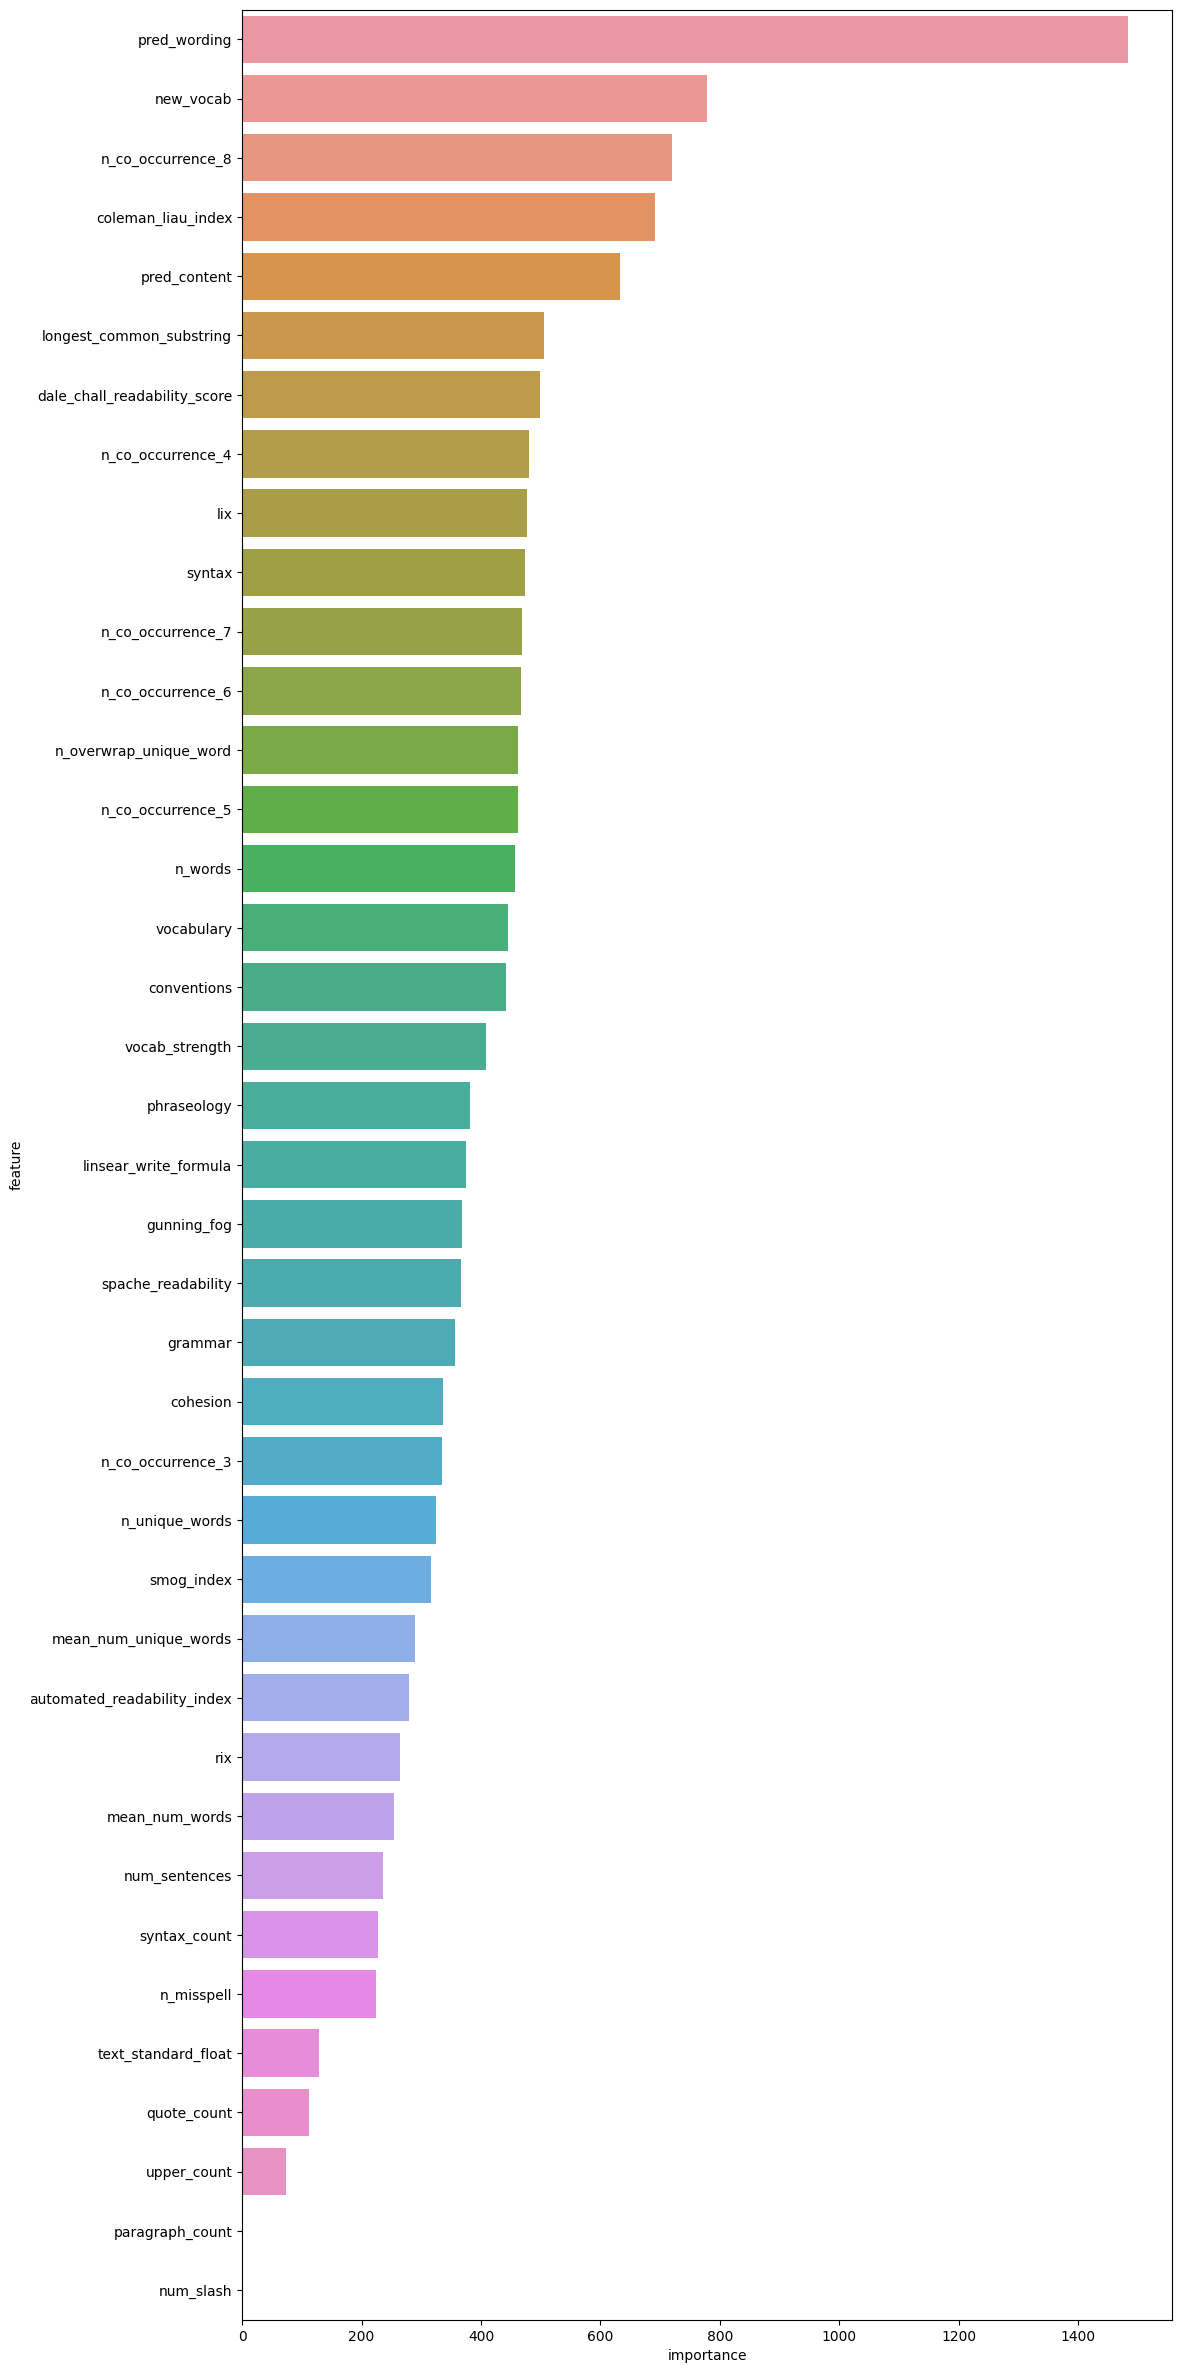

In [42]:
importance_df = pd.DataFrame()
for fold in range(cfg.num_fold):
    model = pickle.load(open(cfg.EXP_MODEL / f"lgbm_fold{fold}_wording.pkl", "rb"))
    _df = pd.DataFrame()
    _df["feature"] = model.feature_name()
    _df["importance"] = model.feature_importance()
    _df["fold"] = fold
    importance_df = pd.concat([importance_df, _df], axis=0)

importance_df.groupby("feature").agg({"importance": ["mean", "std"]}).sort_values(("importance", "mean"), ascending=False)

fig, ax = plt.subplots(figsize=(12, 30))
sns.barplot(x="importance", y="feature", data=importance_df.groupby("feature").agg({"importance": "mean"}).reset_index().sort_values("importance", ascending=False), ax=ax)

In [43]:
!pip install -qq kaggle
from pathlib import PosixPath
from kaggle.api.kaggle_api_extended import KaggleApi
dataset_create_new(dataset_name=Config.NAME, upload_dir=Config.EXP)

Starting upload for file tokenizer.tar


100%|██████████| 2.36M/2.36M [00:00<00:00, 5.29MB/s]


Upload successful: tokenizer.tar (2MB)
Starting upload for file model.tar


100%|██████████| 13.0G/13.0G [03:25<00:00, 67.9MB/s]


Upload successful: model.tar (13GB)
Starting upload for file fig.tar


100%|██████████| 10.0k/10.0k [00:00<00:00, 28.8kB/s]


Upload successful: fig.tar (10KB)
Starting upload for file preds.tar


100%|██████████| 210k/210k [00:00<00:00, 456kB/s]


Upload successful: preds.tar (210KB)
